# Project Details 
- We are given 'sentiment140' dataset. The dataset contains 1,600,000 tweets.
-  target class has : 0 = negative, 2 = neutral, 4 = positive, for sentiments calssification
- There are 6 columns : target,ids, date,flag,user,text
- We are mainly concerned with text and target columns

# Our Approach : 
In our report, we will discuss 3 main models : CNN, LSTM, Hybrid
We proposes and evaluate different architectures using these models. We will be using tensorflow for this project. 
- CNN (another notebook) 

- LSTM 
 - Architecture 1 : basic LSTM model
 - Architecture 2 : bi-directional LSTM model
 - Architecture 3 : Glove + LSTM 
 - Architecture 3.1 : Glove + additional dropout + LSTM 
- Hybrid 
  - Architecture 1 : Glove + CNN + LSTM 
  - Architecture 2 : Glove + LSTM + CNN  

We tested our project on Google collab


# Install the pre-requistics : 

In [0]:
!pip install nltk
!pip install contractions
!pip install tensorflow
#!pip install tensorflow-gpu

     |████████████████████████████████| 317kB 32.5MB/s 
     |████████████████████████████████| 245kB 45.8MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81704 sha256=86e6f87d2473f07668c9b387b136392ad2638949986184255bb801e23fb86d28
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


# Libraries we are importing
- pandas : Data processing library, used to store the dataset in a Dataframe
- numpy : used mainly for any scientific computing
- sklearn : ML library in python
- tensorflow : Google's Deep Learning Library
- matplotlib : to get plots

Please ensure that you have your runtime set to GPU :
Runtime --> change runtime type --> Hardware accelator = GPU

In [0]:
import pandas as pd
import tensorflow as tf
print(tf.__version__)
print("Our tensorflow version = 2.2.0-rc3")
import csv
import numpy as np
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
import contractions as cont_lib

import matplotlib.pyplot as plt

# Checking for GPU 
import timeit
from collections import Counter  # to counts the distribution of classes in the dataset

tf.test.is_gpu_available #show if tensorflow has accuss to cuda gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.2.0-rc3
Our tensorflow version = 2.2.0-rc3
Found GPU at: /device:GPU:0


# Steps taken:

- Data is loaded into pandas
- Text Data is cleaned (we will do basic pre-processing as we still dont know if or if not removing stop words, lemmatisation, stemming is better or not. Also label encoding is done). Pre-processed_data is used to verify all models in this project
- Split the dataset into train and test
- Both the data is tokenised, and padded. 
- Train dataset is used for model training, and test dataset for evaluation

# Hyper-parameters
these are declared at the top as it is easy to change when needed

In [0]:
# use glove 100 file
embedding_dim = 64 # This gives the size of the feature vector
max_length = 30 # max word length of sentences held in sequences
# max_length = df['text_after_preprocess'].apply(lambda x : len(x.split(' '))).quantile(0.99)
trunc_type = 'post' # we truncate at the end
padding_type = 'post' #we padd at the end
oov_tok = '<OOV>'
training_portion = .8 # proportion of training data that is split

# CNN parameters # verified in another notebook
maxLength = 40 # max word length of sentences held in sequences.  Cutting it in half drops accuracy and worsens loss by about 1%. 
eDepth = 200 #depth of the embedding layer.   
bSize = 128 #batch size for conv layer 
fSize = 5 #feature size for conv layer
cEpochs = 10 #epoch number for conv layer 
dOut = 0.3 #dropout rate for drop layer
cActivation = 'relu' #activation type for conv layer. Default was 'relu'

# Read the file 
- We mounted the file in Google drive when running it 
- But, we will comment this command off, and add the csv file so that the local path would be same incase it is run again

In [0]:
from google.colab import drive
drive.mount('/content/drive')
#df = pd.read_csv("/content/drive/My Drive/TwitterData.csv", encoding = 'ISO-8859–1',  names=["target", "ids", "date", "flag", "user", "text"]) 
df = pd.read_csv("TwitterData.csv", encoding = 'ISO-8859–1',  names=["target", "ids", "date", "flag", "user", "text"]) 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df.head(2)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


# Pre-processing : 
- We have done very little pre-processing : No stemming, POS tagging, Lemmatisation, or other NLP tasks
- We have tokenised the text 
- 2-fold Contarction mapping is done (eg. can't --> can not). This is mainly because the library contractions found does only basic mappings. Hence we added extra mappings. We used wikipedia as a refernce when defining the function contractions below. 
- Our belief is that DL models should be able to perform well even with minimal pre-processing or as people call it "expert" feature engineering

In [0]:
def contractions(text):
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'a", " have", text)
    return text

def preprocess(text):
    # Remove link,user and special characters
    text = re.sub('@[^ ]+ ', '', text) #remove user @ tags
    text = re.sub('http[^ ]+ ', '', text) #remove hyperlinks 
    text = re.sub('[^a-zA-Z1-9]', ' ', text) #remove special characters left over 
    text = re.sub(r'\s+', ' ', text) #remove multiple spaces
    text = text.lstrip() #remove trailing spaces
    text = text.rstrip()    
    text = contractions(text)
    tokens = []
    for token in text.split():
        tokens.append(cont_lib.fix(token))
    return " ".join(tokens)

In [0]:
sent = "you've three, so can't dont"
print(contractions(sent))
print(cont_lib.fix(contractions(sent)))

you have three, so can not dont
you have three, so can not do not


In [0]:
df.text = df.text.apply(lambda x: preprocess(x))

In [0]:
df['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

Lets label encode the data, we know
- 0 = negative
- 2 = neutral
- 4 = positive

We need to ensure that there is no class imbalance when training the model. If there is an imbalance, we need to add weights or use other methods to ensure that the model doesnt favour one target class over the other. 

In [0]:
label_encoding = {0: "negative", 2: "neutral", 4: "positive"}
df.target = df.target.apply(lambda x: label_encoding[int(x)])

In [0]:
df.head(1)

,target,ids,date,flag,user,text
0,negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,Awww that s a bummer You shoulda got David Car...


Lets check if there are any null values 

In [0]:
# check is there are any null values. If yes, then drop those
df = df[df['text'].notnull()]
df = df[df['text']!= '']
df = df.reset_index(drop=True)
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [0]:
df.shape

(1596482, 6)

In [0]:
df['text'].apply(lambda x : len(x.split(' '))).quantile(0.99)

30.0

In [0]:
df.to_csv("prepro_final_twitter.csv", sep=";", index = False)

# Pre-processing complete
- Lets save it to a file
- We are only interested in 2 columns : target and text 

In [0]:
#df = pd.read_csv("/content/drive/My Drive/prepro_final_twitter.csv", sep=";") 
df = pd.read_csv("prepro_final_twitter.csv", sep=";")
df.head(1)

,target,ids,date,flag,user,text
0,negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,Awww that s a bummer You shoulda got David Car...


In [0]:
data = df[['target','text']].copy()
data['text'] = data['text'].astype(str)
display(data.head(1))
data.shape

,target,text
0,negative,Awww that s a bummer You shoulda got David Car...


(1596482, 2)

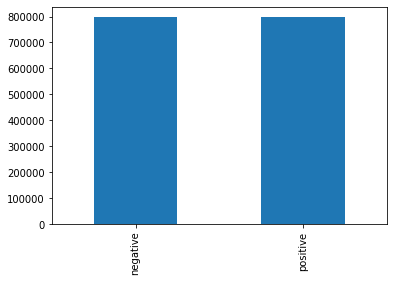

In [0]:
class_dist = data.target.value_counts()
class_dist.plot(kind='bar')
plt.show()

## Split the dataset
- We can note that the target class has an equal distribution before the split. 
- We need to check the distribution after the split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data['text'].tolist(), data['target'].tolist(), test_size=0.20, random_state=17)
print(X_train[1])
print(Y_train[1])

I am about to go watch Americas Most Wanted
positive


In [0]:
# get an idea of the distribution in train dataset 
count = Counter(Y_train)
print('Distribution of the classes in Train dataset:', count)

Distribution of the classes in Train dataset: Counter({'negative': 638603, 'positive': 638582})


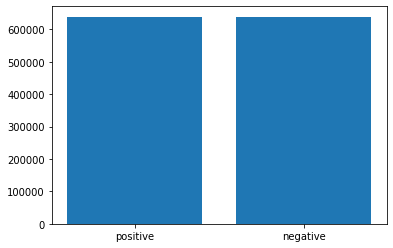

In [0]:
plt.bar(count.keys(), count.values())
plt.show()

# Tokenising and other preparation 
- fit_on_text will go through all the text and create dictionary
- The sequences that we use to train the nueral networks should have same length. In our dataset, the max_length is 50. 
- So we post pad the data accordingly (Pad at the end of the sequence, and trunkate at the end if needed) 

In [0]:
# tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# We note the vocab_size :  total number of words in text +1 since 0 is used for padding
vocab_size = len(tokenizer.word_index)+1 

# create sequences 
X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)

#pad sequences that are less than the max so that all sequences are the same length 
X_train_final = pad_sequences(X_train, padding=padding_type, maxlen=max_length, truncating=trunc_type) 
X_test_final = pad_sequences(X_test, padding=padding_type, maxlen=max_length, truncating=trunc_type)

# do the same for label 
label_tokenizer = Tokenizer()

label_tokenizer.fit_on_texts(Y_train)
Y_train_final = np.array(label_tokenizer.texts_to_sequences(Y_train))

label_tokenizer.fit_on_texts(Y_test)
Y_test_final = np.array(label_tokenizer.texts_to_sequences(Y_test))

In [0]:
print('Total no. of Tokens:', vocab_size,'\n')
print('tweet : ', X_train[2])
print('tweet : ', Y_train[2],'\n')
print('model interpretation of the tweet : ', X_train_final[2] , '\n')
print('model interpretation of the tweet : ', Y_train_final[2] , '\n')

print(X_train_final.shape)
print(Y_train_final.shape)

print(X_test_final.shape)
print(Y_test_final.shape)

Total no. of Tokens: 272612 

tweet :  [97926, 1, 55, 2, 38, 4, 4323, 41, 992, 1649, 992, 20, 3, 4537, 1880]
tweet :  positive 

model interpretation of the tweet :  [97926     1    55     2    38     4  4323    41   992  1649   992    20
     3  4537  1880     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0] 

model interpretation of the tweet :  [2] 

(1277185, 30)
(1277185, 1)
(319297, 30)
(319297, 1)


# Model trainings 
We have tokenised and padded our training and test data. Now we will propose and evaluate different architectures. Lets start with CNN which will be our baseline

# Code for plotting

In [0]:
def plot_graphs(history, string_needed):
  plt.plot(history.history[string_needed])
  plt.plot(history.history['val_'+string_needed])
  plt.xlabel("Epoch values")
  plt.ylabel(string_needed)
  plt.legend(['train', 'test'], loc = 'upper left')
  plt.show()

# Model 1 : CNN is done in another notebook

# model 2 : LSTM

- Embedding layer : its a matrix of word vectors. It stores 1 vector per word. The input vocab size is (vocab+1) and output is 128
- LSTM : type of RNN that enables 'building' of the state over time unlike RNN
- Dense layer : we have 3 output classes. It uses softmax activation function.  
- When we have 3 outputs, softmax convert outputs layers into a probability distribution for these 3 classes.

Lets start with a basic 3-layer model

In [0]:
lstm_1 = tf.keras.Sequential()
lstm_1.add(tf.keras.layers.Embedding(input_dim = vocab_size+1,input_length=30, output_dim=64))
lstm_1.add(tf.keras.layers.LSTM(128))
lstm_1.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_1.add(tf.keras.layers.Dense(3, activation='softmax'))
lstm_1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 64)            17447232  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 17,554,499
Trainable params: 17,554,499
Non-trainable params: 0
_________________________________________________________________


In [0]:
#train model 
lstm_arch_1 = lstm_1.fit(X_train_final, Y_train_final,batch_size=256, epochs=10, verbose=1, validation_split=0.2) 
lstm_score_1 = lstm_1.evaluate(X_test_final, Y_test_final, verbose=1)

Epoch 1/10
3992/3992 [==============================] - 664s 166ms/step - loss: 0.4317 - accuracy: 0.7982 - val_loss: 0.3956 - val_accuracy: 0.8209
Epoch 2/10
3992/3992 [==============================] - 659s 165ms/step - loss: 0.3574 - accuracy: 0.8419 - val_loss: 0.4000 - val_accuracy: 0.8201
Epoch 3/10
3992/3992 [==============================] - 656s 164ms/step - loss: 0.3135 - accuracy: 0.8645 - val_loss: 0.4100 - val_accuracy: 0.8202
Epoch 4/10
3992/3992 [==============================] - 658s 165ms/step - loss: 0.2743 - accuracy: 0.8831 - val_loss: 0.4446 - val_accuracy: 0.8118
Epoch 5/10
3992/3992 [==============================] - 656s 164ms/step - loss: 0.2384 - accuracy: 0.8991 - val_loss: 0.5064 - val_accuracy: 0.8106
Epoch 6/10
3992/3992 [==============================] - 655s 164ms/step - loss: 0.2100 - accuracy: 0.9111 - val_loss: 0.5487 - val_accuracy: 0.8072
Epoch 7/10
3992/3992 [==============================] - 655s 164ms/step - loss: 0.1890 - accuracy: 0.9202 - val_

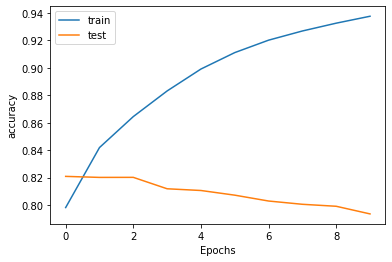

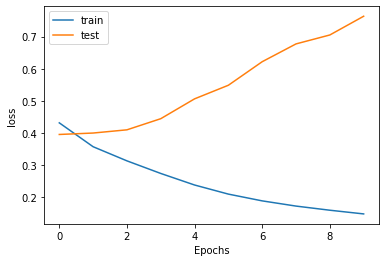

In [0]:
plot_graphs(lstm_arch_1, "accuracy")
plot_graphs(lstm_arch_1, "loss");

# Model 2 Architecture 2 : Bidirectional LSTM
- We'll use Bidirectional LSTM. This layer reads in both directions : forward and backward and allows the model to access the information from both the past as well as the future. 
- It performs better than LSTM
- Dropout is added. It helps to reduce over-fitting. ![alt text](https://)

In [0]:
lstm_2 = tf.keras.Sequential()
lstm_2.add(tf.keras.layers.Embedding(input_dim = vocab_size,input_length=30, output_dim=64))
lstm_2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25)))
lstm_2.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_2.add(tf.keras.layers.Dense(3, activation='softmax'))
lstm_2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 64)            17447168  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 17,521,667
Trainable params: 17,521,667
Non-trainable params: 0
_________________________________________________________________


In [0]:
#train model 
lstm_arch_2 = lstm_2.fit(X_train_final, Y_train_final,batch_size=256, epochs=10, verbose=1, validation_split=0.2) 
lstm_score_2 = lstm_2.evaluate(X_test_final, Y_test_final, verbose=1)

Epoch 1/10
3992/3992 [==============================] - 659s 165ms/step - loss: 0.4236 - accuracy: 0.8051 - val_loss: 0.3944 - val_accuracy: 0.8213
Epoch 2/10
3992/3992 [==============================] - 661s 166ms/step - loss: 0.3624 - accuracy: 0.8390 - val_loss: 0.3967 - val_accuracy: 0.8212
Epoch 3/10
3992/3992 [==============================] - 664s 166ms/step - loss: 0.3257 - accuracy: 0.8580 - val_loss: 0.4042 - val_accuracy: 0.8200
Epoch 4/10
3992/3992 [==============================] - 660s 165ms/step - loss: 0.2952 - accuracy: 0.8728 - val_loss: 0.4205 - val_accuracy: 0.8183
Epoch 5/10
3992/3992 [==============================] - 660s 165ms/step - loss: 0.2680 - accuracy: 0.8856 - val_loss: 0.4464 - val_accuracy: 0.8158
Epoch 6/10
3992/3992 [==============================] - 658s 165ms/step - loss: 0.2436 - accuracy: 0.8964 - val_loss: 0.4791 - val_accuracy: 0.8135
Epoch 7/10
3992/3992 [==============================] - 658s 165ms/step - loss: 0.2245 - accuracy: 0.9044 - val_

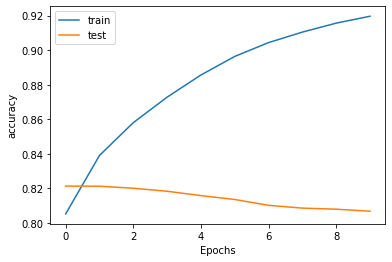

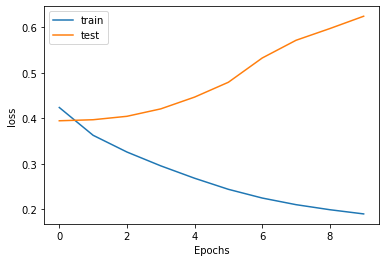

In [0]:
plot_graphs(lstm_arch_2, "accuracy")
plot_graphs(lstm_arch_2, "loss");

# Model 2 architecture 3 : glove + LSTM 
- Initially we are building the word vectores from scratch, but instead we can use pre-trained word vectors trained against several billions of documents. 
- Using Transfer Learning helps improve performance. Its a type of learning where the existing model weights are changed, and rather used for a new task
- We are using Glove embeddings : there is a specail twitter data thats present in Glove
- This should imporve the performance


In [0]:
#file used for glove embeddings 
#embeddingsFile = '/content/drive/My Drive/glove.twitter.27B.100d.txt' 
embeddingsFile = "glove.twitter.27B.100d.txt"
embedding_dim=100
embeddings_index = {};
with open(embeddingsFile) as file:
    for line in file:
        values = line.split();
        phrase = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embeddings_index[phrase] = coefficients;
        
#the input matrix for the embedding_layer.  must be size (batch, input_length) 
#each column wil contain the GloVe word embeddings for the words from each row

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [0]:
lstm_3_relu = tf.keras.Sequential()
lstm_3_relu.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim=100, input_length=max_length, weights=[embeddings_matrix], trainable=False))
lstm_3_relu.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25)))
lstm_3_relu.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_3_relu.add(tf.keras.layers.Dense(3, activation='softmax'))
lstm_3_relu.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_3_relu.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 100)           27261200  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 195       
Total params: 27,354,131
Trainable params: 92,931
Non-trainable params: 27,261,200
_________________________________________________________________


In [0]:
#train model 
lstm_arch_3_relu = lstm_3_relu.fit(X_train_final, Y_train_final,batch_size=256, epochs=20, verbose=1, validation_split=0.2) 
lstm_score_3_relu = lstm_3_relu.evaluate(X_test_final, Y_test_final, verbose=1)

Epoch 1/20
3992/3992 [==============================] - 38s 9ms/step - loss: 0.4594 - accuracy: 0.7810 - val_loss: 0.4198 - val_accuracy: 0.8090
Epoch 2/20
3992/3992 [==============================] - 37s 9ms/step - loss: 0.4203 - accuracy: 0.8050 - val_loss: 0.4017 - val_accuracy: 0.8169
Epoch 3/20
3992/3992 [==============================] - 37s 9ms/step - loss: 0.4073 - accuracy: 0.8127 - val_loss: 0.3917 - val_accuracy: 0.8223
Epoch 4/20
3992/3992 [==============================] - 37s 9ms/step - loss: 0.3991 - accuracy: 0.8176 - val_loss: 0.3879 - val_accuracy: 0.8250
Epoch 5/20
3992/3992 [==============================] - 37s 9ms/step - loss: 0.3936 - accuracy: 0.8208 - val_loss: 0.3899 - val_accuracy: 0.8220
Epoch 6/20
3992/3992 [==============================] - 38s 10ms/step - loss: 0.3889 - accuracy: 0.8232 - val_loss: 0.3957 - val_accuracy: 0.8226
Epoch 7/20
3992/3992 [==============================] - 37s 9ms/step - loss: 0.3857 - accuracy: 0.8248 - val_loss: 0.3789 - val_a

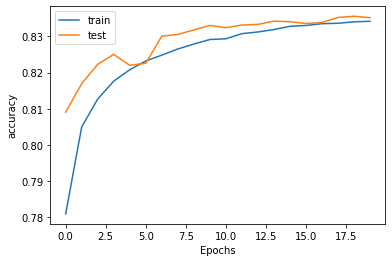

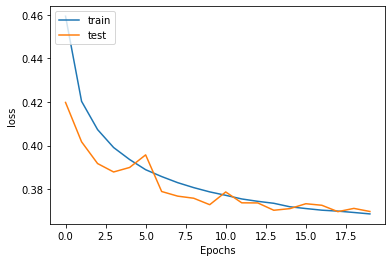

In [0]:
plot_graphs(lstm_arch_3_relu, "accuracy")
plot_graphs(lstm_arch_3_relu, "loss")

In [0]:
checkpoint_path = "./checkpoints/weights"
lstm_3.save_weights(checkpoint_path)
lstm_3.save("lstm_3.h5")

# Model 2 architecture 4 : glove + additional dropout + LSTM 
- tf.keras.layers.Dropout(0.25) : loss: 0.3851 - accuracy: 0.8264
- tf.keras.layers.SpatialDropout1D(0.25) : loss: 0.3903 - accuracy: 0.8243

Adding dropout after LSTM layer : 
- tf.keras.layers.Dropout(0.25): loss: 0.3910 - accuracy: 0.8258

Adding recurrent dropout : 
- tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2) : loss: 0.3884 - accuracy: 0.8259

Spatial Droput : same function as dropout, but drops the entire 1D feature map. Mianly used when the individual elemnts are strongly co-related, as this would regularise it better and enhances independence between feature maps. As expected, its not making much of a difference. 

- Not having a extra dropout layer has better results


In [0]:
lstm_4_dropout = tf.keras.Sequential()
lstm_4_dropout.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim=100, input_length=max_length, weights=[embeddings_matrix], trainable=False))
lstm_4_dropout.add(tf.keras.layers.SpatialDropout1D(0.25))
lstm_4_dropout.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25)))
lstm_4_dropout.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_4_dropout.add(tf.keras.layers.Dense(3, activation='softmax'))
lstm_4_dropout.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_4_dropout.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 30, 100)           27261200  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 100)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 195       
Total params: 27,354,131
Trainable params: 92,931
Non-trainable params: 27,261,200
_________________________________________________________________


In [0]:
#train model 
lstm_arch_4_dropout = lstm_4_dropout.fit(X_train_final, Y_train_final,batch_size=256, epochs=10, verbose=1, validation_split=0.2) 
lstm_score_4_dropout = lstm_4_dropout.evaluate(X_test_final, Y_test_final, verbose=1)

Epoch 1/10
3992/3992 [==============================] - 39s 10ms/step - loss: 0.4932 - accuracy: 0.7582 - val_loss: 0.4310 - val_accuracy: 0.7994
Epoch 2/10
3992/3992 [==============================] - 38s 9ms/step - loss: 0.4491 - accuracy: 0.7876 - val_loss: 0.4117 - val_accuracy: 0.8118
Epoch 3/10
3992/3992 [==============================] - 38s 10ms/step - loss: 0.4347 - accuracy: 0.7959 - val_loss: 0.4026 - val_accuracy: 0.8174
Epoch 4/10
3992/3992 [==============================] - 38s 10ms/step - loss: 0.4267 - accuracy: 0.8011 - val_loss: 0.3958 - val_accuracy: 0.8211
Epoch 5/10
3992/3992 [==============================] - 38s 9ms/step - loss: 0.4210 - accuracy: 0.8042 - val_loss: 0.3930 - val_accuracy: 0.8224
Epoch 6/10
3992/3992 [==============================] - 38s 10ms/step - loss: 0.4172 - accuracy: 0.8065 - val_loss: 0.4000 - val_accuracy: 0.8198
Epoch 7/10
3992/3992 [==============================] - 38s 9ms/step - loss: 0.4133 - accuracy: 0.8091 - val_loss: 0.3904 - va

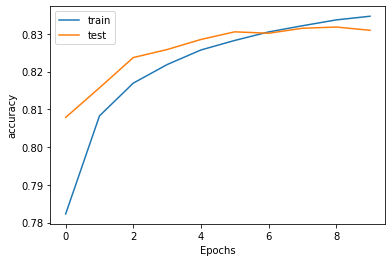

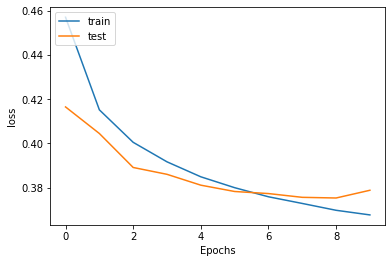

In [0]:
plot_graphs(lstm_arch_4_dropout, "accuracy")
plot_graphs(lstm_arch_4_dropout, "loss")

# Hyper-parameter tuning results for LSTM archit 3

Test 1 : Dropout of 0.25,0.5,0.75 in Bi-dir LSTM layer, Batch size = 256
- 0 = loss: 0.3856 - accuracy: 0.8267
- 0.15 = loss: 0.3799 - accuracy: 0.8303
- 0.2 = 
- 0.25 = loss: 0.3766 - accuracy: 0.8313
- 0.5 = loss: 0.3987 - accuracy: 0.8210
- 0.75 = loss: 0.4304 - accuracy: 0.8041

---
Test 2 : Activation function - relu or tanh in the first dense layer
Batch size = 256, loss= sparse_categorical_crossentropy , dropout = 0.25
  - relu = loss: 0.3726 - accuracy: 0.8336
  - tanh =  loss: 0.3760 - accuracy: 0.8331 

inference : Relu does very slightly better than tanh

---
Test 3 : Batch size of 32, 128, 256, 1024
Last layer Dense(3, activation = 'softmax'), loss= sparse_categorical_crossentropy, dropout = 0.25

- 32 = loss: 0.3821 - accuracy: 0.8307
- 128 = loss: 0.3738 - accuracy: 0.8336
- 256 = loss: 0.3766 - accuracy: 0.8313
- 1024 = loss: 0.3741 - accuracy: 0.8339

inference : I will choose 128 as the batch sizes are not making a huge impact on the results. But increasing the batch size is increasing the running time. 

--- 
Test 4 : 
- using normal Glove embedding file would reduce the accuracy by a small percentage, when compared to Glove Twitter file (around 1%, but cuts learning time in about half) 
- glove.twitter.27B.200d.txt improves the accuracy slightly than glove.twitter.27B.100d.txt


# Model 3 : Hybrid model 
- Architecture 1 : Glove + CNN + LSTM
- We wanted to combine both these approaches

In [0]:
hybrid_1 = tf.keras.Sequential()
hybrid_1.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim=100, input_length=max_length, weights=[embeddings_matrix], trainable=False))
hybrid_1.add(tf.keras.layers.Conv1D(bSize, 5, activation='relu'))
hybrid_1.add(tf.keras.layers.Dropout(dOut))
hybrid_1.add(tf.keras.layers.MaxPooling1D())
hybrid_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25)))
hybrid_1.add(tf.keras.layers.Dense(64, activation='relu'))
hybrid_1.add(tf.keras.layers.Dense(3, activation='softmax'))
hybrid_1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
hybrid_1.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 30, 100)           27261200  
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 26, 128)           64128     
_________________________________________________________________
dropout_6 (Dropout)          (None, 26, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 128)           0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 3)               

In [0]:
#train model 
hybrid_arch_1 = hybrid_1.fit(X_train_final, Y_train_final,batch_size=128, epochs=20, verbose=1, validation_split=0.2) 
hybrid_score_1 = hybrid_1.evaluate(X_test_final, Y_test_final, verbose=1)

Epoch 1/20
7983/7983 [==============================] - 61s 8ms/step - loss: 0.4480 - accuracy: 0.7882 - val_loss: 0.4143 - val_accuracy: 0.8083
Epoch 2/20
7983/7983 [==============================] - 59s 7ms/step - loss: 0.4171 - accuracy: 0.8075 - val_loss: 0.4032 - val_accuracy: 0.8159
Epoch 3/20
7983/7983 [==============================] - 60s 7ms/step - loss: 0.4075 - accuracy: 0.8130 - val_loss: 0.3965 - val_accuracy: 0.8200
Epoch 4/20
7983/7983 [==============================] - 59s 7ms/step - loss: 0.4015 - accuracy: 0.8162 - val_loss: 0.3930 - val_accuracy: 0.8215
Epoch 5/20
7983/7983 [==============================] - 59s 7ms/step - loss: 0.3976 - accuracy: 0.8185 - val_loss: 0.3909 - val_accuracy: 0.8226
Epoch 6/20
7983/7983 [==============================] - 58s 7ms/step - loss: 0.3944 - accuracy: 0.8204 - val_loss: 0.3903 - val_accuracy: 0.8231
Epoch 7/20
7983/7983 [==============================] - 58s 7ms/step - loss: 0.3918 - accuracy: 0.8216 - val_loss: 0.3883 - val_ac

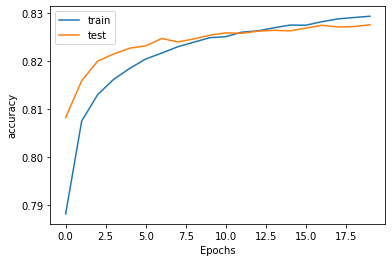

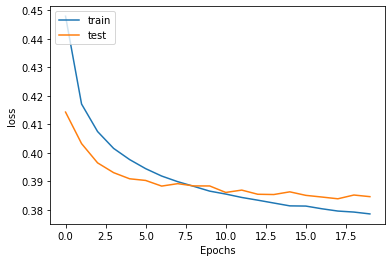

In [0]:
plot_graphs(hybrid_arch_1, "accuracy")
plot_graphs(hybrid_arch_1, "loss");

# Hybrid Arch 2 : glove + LSTM + CNN


In [0]:
hybrid_2 = tf.keras.Sequential()
hybrid_2.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim=100, input_length=max_length, weights=[embeddings_matrix], trainable=False))
hybrid_2.add(tf.keras.layers.SpatialDropout1D(0.25))
hybrid_2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25,return_sequences=True)))
hybrid_2.add(tf.keras.layers.Conv1D(64,4,activation=cActivation ))
hybrid_2.add(tf.keras.layers.GlobalMaxPool1D())
hybrid_2.add(tf.keras.layers.Dense(64, activation='relu'))
hybrid_2.add(tf.keras.layers.Dense(3, activation='softmax'))

hybrid_2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
hybrid_2.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 30, 100)           27261200  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 100)           0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 30, 128)           84480     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 27, 64)            32832     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_30 (Dense)             (None, 3)               

In [0]:
#train model 
hybrid_arch_2 = hybrid_2.fit(X_train_final, Y_train_final,batch_size=128, epochs=20, verbose=1, validation_split=0.2) 
hybrid_score_2 = hybrid_2.evaluate(X_test_final, Y_test_final, verbose=1)

Epoch 1/20
7983/7983 [==============================] - 66s 8ms/step - loss: 0.4670 - accuracy: 0.7755 - val_loss: 0.4190 - val_accuracy: 0.8081
Epoch 2/20
7983/7983 [==============================] - 66s 8ms/step - loss: 0.4270 - accuracy: 0.8015 - val_loss: 0.3958 - val_accuracy: 0.8212
Epoch 3/20
7983/7983 [==============================] - 65s 8ms/step - loss: 0.4155 - accuracy: 0.8084 - val_loss: 0.3899 - val_accuracy: 0.8246
Epoch 4/20
7983/7983 [==============================] - 65s 8ms/step - loss: 0.4096 - accuracy: 0.8117 - val_loss: 0.3850 - val_accuracy: 0.8264
Epoch 5/20
7983/7983 [==============================] - 64s 8ms/step - loss: 0.4050 - accuracy: 0.8144 - val_loss: 0.3817 - val_accuracy: 0.8286
Epoch 6/20
7983/7983 [==============================] - 64s 8ms/step - loss: 0.4021 - accuracy: 0.8162 - val_loss: 0.3800 - val_accuracy: 0.8295
Epoch 7/20
7983/7983 [==============================] - 65s 8ms/step - loss: 0.4001 - accuracy: 0.8172 - val_loss: 0.3840 - val_ac

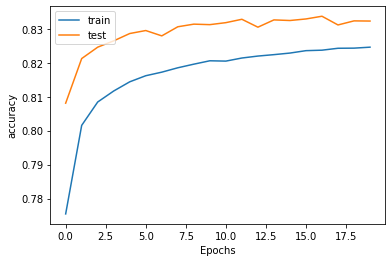

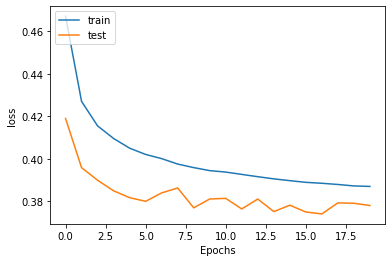

In [0]:
plot_graphs(hybrid_arch_2, "accuracy")
plot_graphs(hybrid_arch_2, "loss");

In [0]:
# To save the model in HDF5 format, we use '.h5' extension 
# saves weights
hybrid_2.save_weights('./checkpoints/hybrid_2')
hybrid_2.save('hybrid_arch_2.h5') 